In [2]:
import os
results_dir = os.path.join(os.path.dirname(os.getcwd()), 'models')

In [2]:
%reload_ext autoreload
%autoreload 2

## prepare dataset

In [3]:
from datasets import load_dataset

input_dir = "/home/yuan/results/epitope/"

# load data
data_files = {
    'train': [
        input_dir + "epitope.txt",
        input_dir + "other.txt",
    ],
}
ds = load_dataset(
    'csv',
    delimiter='\t',
    column_names=['text', 'label'],
    data_files=data_files,
    split='train'
)

In [4]:
# shuffling
ds = ds.shuffle(seed=42)

def update_label(example):
    example['label'] = 1 if example['label'] == 'epitope' else 0
    return example
ds = ds.map(update_label)
os.path.join(results_dir, 'ds')

# split data
ds = ds.train_test_split(test_size=0.05)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3023723
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 159144
    })
})

In [5]:
ds['test'][:10]

{'text': ['ASVIALELL',
  'LGDELGTDPYEDFQE',
  'TTVPEEELNPK',
  'IPVAPTVVN',
  'PKTLDLRGRAQALMRSF',
  'TLGLSCGVG',
  'LVNDDEQPE',
  'NEFPFGCPP',
  'VMWRDWEESR',
  'GNFYDNIVVENDGSG'],
 'label': [0, 1, 1, 0, 1, 0, 0, 1, 0, 0]}

In [6]:
# save
ds.save_to_disk(os.path.join(results_dir, 'ds_epitope'))

Saving the dataset (0/1 shards):   0%|          | 0/3023723 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/159144 [00:00<?, ? examples/s]

## load dataset and model

In [3]:
from unsloth import FastLanguageModel

# max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
max_seq_length = 50
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True

model_name = "unsloth/llama-3-8b-bnb-4bit"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    load_in_4bit = load_in_4bit,
    max_seq_length = max_seq_length,
    dtype = dtype,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    NVIDIA GeForce RTX 3060. Num GPUs = 1. Max memory: 11.634 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.0. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
from datasets import load_from_disk
ds = load_from_disk(os.path.join(results_dir, 'ds'))

## compare prompts

### prompt 1

In [6]:
# format data
catogories = ['No', 'Yes']
rank_to_label = {i:n for i,n in enumerate(catogories)}
label_to_rank = {n:i for i,n in enumerate(catogories)}

# def format_data(example, tokenizer, rank_to_label):
#     word_label = rank_to_label[example['label']]
#     example['token'] = tokenizer.encode(word_label, add_special_tokens=False)[0]
#     return example
# ds = ds.map(format_data, fn_kwargs={'tokenizer': tokenizer, 'rank_to_label': rank_to_label})

prompt = """
Here is an amino acid sequence:
{}

Is this sequence identified as Yes or No ? Answer with "Yes" or "No".

SOLUTION
The correct answer is:
{}
"""

In [7]:
# evaluate the prompt and pre-trained model using partial data
import pandas as pd
from fine_tune import FineTune

stat = pd.DataFrame()
ft = FineTune(model, tokenizer)
chunk_size = 200
for i in range(0, 1000, chunk_size):
    sub = ds['test'][i:i+chunk_size]
    sub=[{'text':k, 'label':v} for k,v in zip(sub['text'], sub['label'])]
    print(i, end=',')
    sub_stat = ft.predict(sub, prompt, label_to_rank)
    stat = pd.concat([stat, sub_stat])

0,

  0%|                                                                                                                                   | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [12]:
stat.head()

,probabilities,predicts,y_pred,y_true
0,0.178711,Yes,1.0,1
1,0.219727,No,0.0,1
2,0.211914,No,0.0,0
3,0.243164,Yes,1.0,0
4,0.219727,No,0.0,0


In [14]:
from collections import Counter
Counter(stat['predicts'])

Counter({'Yes': 668,
         'No': 327,
         ' Is': 2,
         '\n\n': 1,
         ' Answer': 1,
         'Olution': 1})

In [16]:
from trainer_plot import TrainerPlot
TrainerPlot.scores(stat)

Total:  995
true classifications: Counter({1: 547, 0: 448})
predictions:  Counter({1.0: 668, 0.0: 327})


{'recall': 0.696526508226691,
 'precision': 0.5703592814371258,
 'F1 score': 0.6271604938271605,
 'accuracy': 0.5447236180904522}

confusion matrix:
 [[161 287]
 [166 381]]


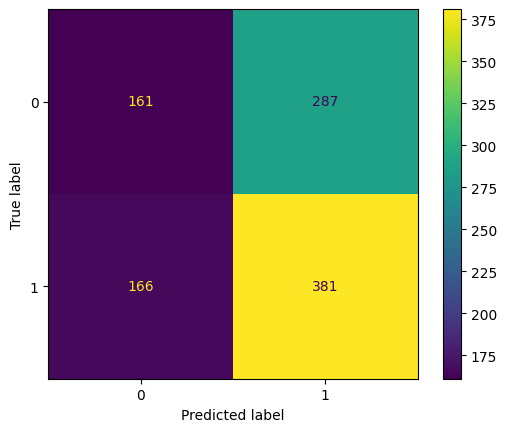

In [18]:
from trainer_plot import TrainerPlot
TrainerPlot.cm(stat)

### prom[t 2

In [29]:
# format data
catogories = ['No', 'Yes']
rank_to_label = {i:n for i,n in enumerate(catogories)}
label_to_rank = {n:i for i,n in enumerate(catogories)}

# def format_data(example, tokenizer, rank_to_label):
#     word_label = rank_to_label[example['label']]
#     example['token'] = tokenizer.encode(word_label, add_special_tokens=False)[0]
#     return example
# ds = ds.map(format_data, fn_kwargs={'tokenizer': tokenizer, 'rank_to_label': rank_to_label})

prompt = """
A text can be classified as one of the following categories: Yes, No.
Based on these categories, classify this text: 
text: {}

answer: {}
"""

In [30]:
# evaluate the prompt and pre-trained model using partial data
import pandas as pd
from fine_tune import FineTune

stat = pd.DataFrame()
ft = FineTune(model, tokenizer)
chunk_size = 200
for i in range(0, 1000, chunk_size):
    sub = ds['test'][i:i+chunk_size]
    sub=[{'text':k, 'label':v} for k,v in zip(sub['text'], sub['label'])]
    print(i, end=',')
    sub_stat = ft.predict(sub, prompt, label_to_rank)
    stat = pd.concat([stat, sub_stat])

0,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.37it/s]


200,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.21it/s]


400,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.41it/s]


600,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.37it/s]


800,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


In [31]:
from collections import Counter
Counter(stat['predicts'])

Counter({'Yes': 913,
         'No': 54,
         'Text': 12,
         'Dk': 5,
         'Te': 3,
         'Ap': 1,
         'Inf': 1,
         'Q': 1,
         'K': 1,
         ' Yes': 1,
         'Sk': 1,
         'Aps': 1,
         'Wr': 1,
         'Lm': 1,
         'Tp': 1,
         'Ac': 1,
         '"""\n': 1,
         'Ad': 1})

In [32]:
from trainer_plot import TrainerPlot
TrainerPlot.scores(stat)

Total:  967
true classifications: Counter({1: 533, 0: 434})
predictions:  Counter({1.0: 913, 0.0: 54})


{'recall': 0.9530956848030019,
 'precision': 0.556407447973713,
 'F1 score': 0.7026279391424619,
 'accuracy': 0.5553257497414684}

confusion matrix:
 [[ 29 405]
 [ 25 508]]


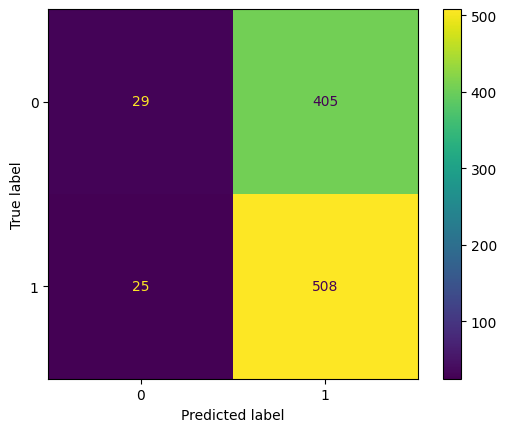

In [33]:
from trainer_plot import TrainerPlot
TrainerPlot.cm(stat)

### prom[t 3

In [22]:
# format data
catogories = ['Other', 'Epitope']
rank_to_label = {i:n for i,n in enumerate(catogories)}
label_to_rank = {n:i for i,n in enumerate(catogories)}

# def format_data(example, tokenizer, rank_to_label):
#     word_label = rank_to_label[example['label']]
#     example['token'] = tokenizer.encode(word_label, add_special_tokens=False)[0]
#     return example
# ds = ds.map(format_data, fn_kwargs={'tokenizer': tokenizer, 'rank_to_label': rank_to_label})

prompt = """
A text can be classified as one of the following categories: Epitope, Other.
Based on these categories, classify this text: 
TEXT: {}

SOLUTION: {}
"""

In [23]:
# evaluate the prompt and pre-trained model using partial data
import pandas as pd
from fine_tune import FineTune

stat = pd.DataFrame()
ft = FineTune(model, tokenizer)
chunk_size = 200
for i in range(0, 1000, chunk_size):
    sub = ds['test'][i:i+chunk_size]
    sub=[{'text':k, 'label':v} for k,v in zip(sub['text'], sub['label'])]
    print(i, end=',')
    sub_stat = ft.predict(sub, prompt, label_to_rank)
    stat = pd.concat([stat, sub_stat])

0,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.34it/s]


200,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.18it/s]


400,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.37it/s]


600,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.35it/s]


800,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.28it/s]


In [24]:
from collections import Counter
Counter(stat['predicts'])

Counter({'The': 962,
         'T': 4,
         'Av': 4,
         'Rd': 3,
         'A': 3,
         '```': 2,
         'Ve': 2,
         'Olution': 2,
         'Q': 1,
         'V': 1,
         'Solution': 1,
         'Ra': 1,
         'Pat': 1,
         'Sw': 1,
         'Aq': 1,
         ' Ep': 1,
         ':': 1,
         'Led': 1,
         'Me': 1,
         'Rw': 1,
         'Pv': 1,
         'Dna': 1,
         'Wk': 1,
         'Te': 1,
         'Pe': 1,
         'Nt': 1})

# evalute pre-trained model using test data

In [5]:
# format data
catogories = ['No', 'Yes']
rank_to_label = {i:n for i,n in enumerate(catogories)}
label_to_rank = {n:i for i,n in enumerate(catogories)}

# def format_data(example, tokenizer, rank_to_label):
#     word_label = rank_to_label[example['label']]
#     example['token'] = tokenizer.encode(word_label, add_special_tokens=False)[0]
#     return example
# ds = ds.map(format_data, fn_kwargs={'tokenizer': tokenizer, 'rank_to_label': rank_to_label})

prompt = """
Here is an amino acid sequence:
{}

Is this sequence identified as Yes or No ? Answer with "Yes" or "No".

SOLUTION
The correct answer is:
{}
"""

In [6]:
# evaluate model using 
import pandas as pd
from fine_tune import FineTune

stat = pd.DataFrame()
ft = FineTune(model, tokenizer)
chunk_size = 1000
for i in range(0, len(ds['test']), chunk_size):
    sub = ds['test'][i:i+chunk_size]
    sub=[{'text':k, 'label':v} for k,v in zip(sub['text'], sub['label'])]
    print(i, end=',')
    sub_stat = ft.predict(sub, prompt, label_to_rank)
    stat = pd.concat([stat, sub_stat])

0,

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 12/14 [00:43<00:03,  1.84s/it]Unsloth: Input IDs of length 51 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 13/14 [00:43<00:01,  1.33s/it]Unsloth: Input IDs of length 52 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.12s/it]


1000,

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 14/17 [00:43<00:02,  1.07it/s]Unsloth: Input IDs of length 53 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 15/17 [00:43<00:01,  1.42it/s]Unsloth: Input IDs of length 54 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.58s/it]


2000,

 69%|███████████████████████████████████████████████████████████████████████████████████▉                                      | 11/16 [00:43<00:07,  1.47s/it]Unsloth: Input IDs of length 55 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 14/16 [00:43<00:01,  1.66it/s]Unsloth: Input IDs of length 60 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


3000,

 21%|█████████████████████████▉                                                                                                 | 4/19 [00:12<00:55,  3.67s/it]Unsloth: Input IDs of length 65 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18/19 [00:44<00:00,  2.06it/s]Unsloth: Input IDs of length 57 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


4000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


5000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


6000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


7000,

 69%|███████████████████████████████████████████████████████████████████████████████████▉                                      | 11/16 [00:43<00:07,  1.50s/it]Unsloth: Input IDs of length 59 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


8000,

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 14/16 [00:43<00:01,  1.45it/s]Unsloth: Input IDs of length 56 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


9000,

 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 12/16 [00:43<00:05,  1.29s/it]Unsloth: Input IDs of length 64 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


10000,

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▎                            | 13/17 [00:43<00:04,  1.05s/it]Unsloth: Input IDs of length 58 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


11000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.13s/it]


12000,

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 14/17 [00:43<00:02,  1.23it/s]Unsloth: Input IDs of length 61 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.59s/it]


13000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


14000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


15000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.23s/it]


16000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


17000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.77s/it]


18000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


19000,

 69%|███████████████████████████████████████████████████████████████████████████████████▉                                      | 11/16 [00:43<00:09,  1.89s/it]Unsloth: Input IDs of length 117 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


20000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.58s/it]


21000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


22000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


23000,

 47%|██████████████████████████████████████████████████████████▎                                                                | 9/19 [00:42<00:49,  4.90s/it]Unsloth: Input IDs of length 484 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.33s/it]


24000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


25000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


26000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.14s/it]


27000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


28000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


29000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


30000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.74s/it]


31000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.74s/it]


32000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.12s/it]


33000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.13s/it]


34000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.77s/it]


35000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


36000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


37000,

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 15/17 [00:43<00:01,  1.63it/s]Unsloth: Input IDs of length 72 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


38000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


39000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


40000,

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 14/17 [00:43<00:02,  1.19it/s]Unsloth: Input IDs of length 62 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


41000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


42000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


43000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.94s/it]


44000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


45000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


46000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.47s/it]


47000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


48000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


49000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.94s/it]


50000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.94s/it]


51000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.12s/it]


52000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


53000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


54000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


55000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


56000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.94s/it]


57000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.58s/it]


58000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:45<00:00,  1.89s/it]


59000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.74s/it]


60000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.14s/it]


61000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


62000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


63000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


64000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.94s/it]


65000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


66000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


67000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


68000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.47s/it]


69000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.32s/it]


70000,

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 18/19 [00:44<00:00,  3.43it/s]Unsloth: Input IDs of length 63 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


71000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


72000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


73000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.59s/it]


74000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


75000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


76000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


77000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


78000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.22s/it]


79000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


80000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.12s/it]


81000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.13s/it]


82000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


83000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


84000,

 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 12/18 [00:43<00:08,  1.37s/it]Unsloth: Input IDs of length 266 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


85000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


86000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.59s/it]


87000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


88000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


89000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


90000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.12s/it]


91000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


92000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.47s/it]


93000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


94000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


95000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


96000,

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 17/19 [00:43<00:00,  2.90it/s]Unsloth: Input IDs of length 270 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.32s/it]


97000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


98000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


99000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


100000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


101000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.61s/it]


102000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


103000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


104000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


105000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


106000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.58s/it]


107000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


108000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.74s/it]


109000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.12s/it]


110000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


111000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.35s/it]


112000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


113000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.58s/it]


114000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


115000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


116000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.61s/it]


117000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


118000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


119000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


120000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


121000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


122000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


123000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


124000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


125000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


126000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.47s/it]


127000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:44<00:00,  2.12s/it]


128000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


129000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


130000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


131000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


132000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.34s/it]


133000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.61s/it]


134000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


135000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


136000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:44<00:00,  3.14s/it]


137000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.46s/it]


138000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


139000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.75s/it]


140000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.61s/it]


141000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


142000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.22s/it]


143000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


144000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.47s/it]


145000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


146000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:44<00:00,  2.32s/it]


147000,

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 17/20 [00:43<00:01,  2.94it/s]Unsloth: Input IDs of length 116 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.21s/it]


148000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


149000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.93s/it]


150000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.74s/it]


151000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.75s/it]


152000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.59s/it]


153000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.13s/it]


154000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.60s/it]


155000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


156000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:43<00:00,  2.59s/it]


157000,

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 13/15 [00:43<00:01,  1.22it/s]Unsloth: Input IDs of length 67 > the model's max sequence length of 50.
We shall truncate it ourselves. It's imperative if you correct this issue first.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


158000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.45s/it]


159000,

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:07<00:00,  1.69it/s]


In [7]:
from collections import Counter
Counter(stat['predicts'])

Counter({'Yes': 105488,
         'No': 52856,
         ' "': 257,
         ' Is': 180,
         ' Answer': 124,
         ' Sequence': 71,
         '\n\n': 43,
         'The': 39,
         '"': 27,
         '•': 22,
         'Olution': 18,
         ' Or': 9,
         'K': 4,
         ' Yes': 3,
         ' As': 1,
         'Q': 1,
         '<|End_Of_Text|>': 1})

In [8]:
from trainer_plot import TrainerPlot
TrainerPlot.scores(stat)

Total:  158344
true classifications: Counter({1: 89602, 0: 68742})
predictions:  Counter({1.0: 105488, 0.0: 52856})


{'recall': 0.6864132497042477,
 'precision': 0.583042620961626,
 'F1 score': 0.6305192475267825,
 'accuracy': 0.5447759308846561}

confusion matrix:
 [[24758 43984]
 [28098 61504]]


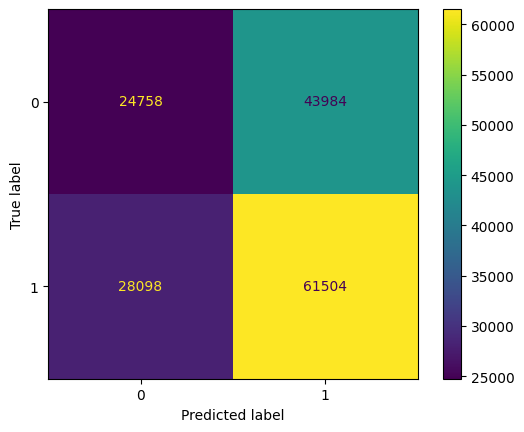

In [9]:
TrainerPlot.cm(stat)